In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, f1_score
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:

# loading stock price data
stock_data = pd.read_csv("data/price.csv")
column = ['close']

## Hyperparameters

We preset the hyperparameter, where we split the training/validation set using the first 85\% of the data while the remaining 15\% will be used for testing.

We use a sequence length where we look at 10 consecutive time steps. We also use 15 epochs and a learning rate of 0.01

In [3]:
# hyperparameters
split = (0.85);
sequence_length = 10;
epochs = 15
learning_rate = 0.01
validation_split = 0.2  # 20% of training data for validation

In [4]:
len_stock_data = stock_data.shape[0]

# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(column).values[:train_examples]
test = stock_data.get(column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]

# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)

# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
X_train = np.array(X_train).astype(float)
y_train = np.array(train[sequence_length:]).astype(float)

# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
X_test = np.array(X_test).astype(float)
y_test = np.array(test[sequence_length:]).astype(float)


## MLP Model

This model is a deep sequential neural network for time series prediction, despite being labeled "MLP" in the comment. It's actually a stacked LSTM architecture:

1. Input Layer:
* Accepts time series data with shape (sequence_length, 1)
* The sequence length is determined by X_train.shape[1]
* Each time step contains one feature
2. Layers:
* First layer: 50 units with tanh activation, returning sequences
* Second layer: 30 units with tanh activation, returning sequences
* Third layer: 20 units with tanh activation, returning only final output
* Each  layer is followed by dropout regularization with progressively
3. Output Layer:
* Single dense neuron with linear activation for regression
4. Training Configuration:
* Optimized with Adam optimizer
* Uses Mean Squared Error loss function
* Includes validation on 20% of training data
* Random seed set for reproducibility

This architecture is designed for time series regression, gradually reducing both the number of units and dropout rates through the network to extract increasingly abstract temporal patterns from the input data.


In [5]:
#creating LSTM model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 50, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.LSTM(units = 20, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )

    # Train the model with validation split
    history = model.fit(
        X_train, y_train,
        epochs = epochs,
        validation_split = validation_split,
        verbose = 1
    )
    
    return model, history

# inverting normaliztion
y_test = scaler.inverse_transform(y_test)


## Model Evaluation

Epoch 1/15
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - loss: 5.7015e-05 - val_loss: 4.1506e-04
Epoch 2/15
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - loss: 1.4795e-05 - val_loss: 3.0010e-04
Epoch 3/15
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 79s 6ms/step - loss: 8.4121e-06 - val_loss: 2.7161e-04
Epoch 4/15
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - loss: 7.0098e-06 - val_loss: 1.5239e-04
Epoch 5/15
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 73s 6ms/step - loss: 6.5343e-06 - val_loss: 2.7823e-04
Epoch 6/15
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 76s 6ms/step - loss: 5.9754e-06 - val_loss: 3.2230e-04
Epoch 7/15
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 76s 6ms/step - loss: 5.6751e-06 - val_loss: 2.0807e-04
Epoch 8/15
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - loss: 5.5741e-06 - val_loss: 4.2766e-04
Epoch 9/15
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - loss: 5.4347e-06 - val_loss: 0.0011
Epoch 10/15
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 76s 6ms/step - loss: 5.2320e-06 - val_loss: 0.0013
Epoch 11/15
12832

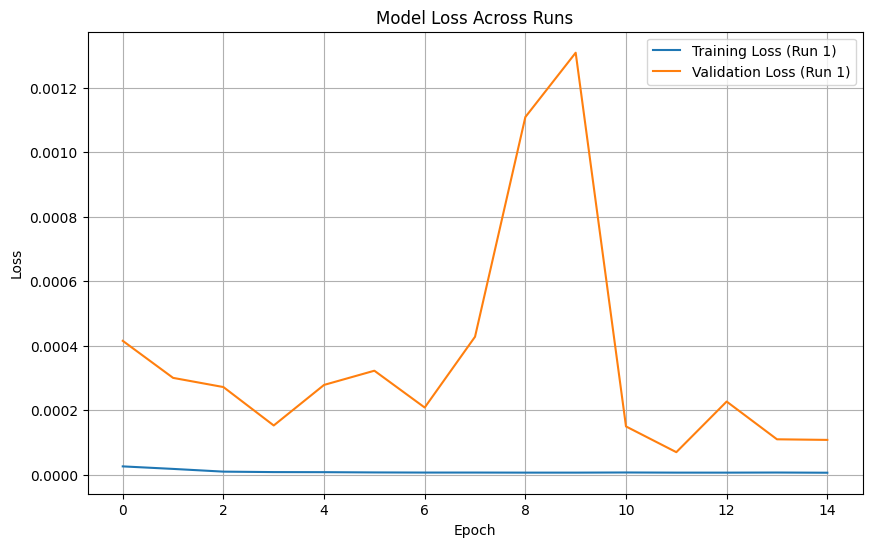

In [6]:
def calculate_r2(y_true, y_pred, in_sample=True, benchmark=None):
    if in_sample:
        return 1 - (
            np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
        )
    else:
        if benchmark is None:
            raise ValueError(
                "Benchmark must be provided for out-of-sample R-squared calculation."
            )
        return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - benchmark) ** 2))

# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions


# evaluation
def evaluate(predictions):
    # Existing metrics
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    r2 = calculate_r2(y_test, predictions, in_sample=False, benchmark=0)
    
    # Convert predictions and actual values to binary classes (1 for increase, 0 for decrease)
    y_pred_binary = np.where(np.diff(predictions.flatten()) > 0, 1, 0)
    y_true_binary = np.where(np.diff(y_test.flatten()) > 0, 1, 0)
    
    # Calculate F1 score
    f1 = f1_score(y_true_binary, y_pred_binary)
    
    return mae, mape, (1 - mape), r2, f1

# trial runs
def run_model(n):
    total_mae = total_mape = total_acc = total_r2 = total_f1 = 0
    histories = []
    global predictions
    for i in range(n):
        model, history = model_create()
        predictions = predict(model)
        mae, mape, acc, r2, f1 = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc
        total_r2 += r2
        total_f1 += f1
        histories.append(history)
    return (total_mae / n), (total_mape / n), (total_acc / n), (total_r2 / n), (total_f1 / n), histories

# Run the model and get the histories
mae, mape, acc, r2, f1, histories = run_model(1)

print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")
print(f"R-squared = {r2}")
print(f"F1 Score = {f1}")
# Plot the final training and validation loss
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Training Loss (Run {i+1})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (Run {i+1})')
plt.title('Model Loss Across Runs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()